In [ ]:
import pandas as pd


In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Input,Lambda, Dense, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.applications import  vgg16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D

In [ ]:

from tensorflow.keras.applications import (
        vgg16,
        resnet50,
        mobilenet,
        inception_v3
    )
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Device: grpc://10.10.232.162:8470
Number of replicas: 8


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [ ]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))


In [ ]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Exception ignored in: <function Executor.__del__ at 0x7aef8a1e71c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Normal images count in training set: 1349


Exception ignored in: <function Executor.__del__ at 0x7aef8a1e71c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Pneumonia images count in training set: 3883


In [ ]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

In [ ]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

class_names = train_ds.class_names
print(class_names)

In [ ]:
inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = layers.Rescaling(1.0 / 255)(inputs)


x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
x = layers.MaxPool2D()(x)
#First
x = layers.SeparableConv2D(32, 3, activation="relu", padding="same")(x)
x = layers.SeparableConv2D(16, 3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
#Second
x = layers.SeparableConv2D(64, 3, activation="relu", padding="same")(x)
x = layers.SeparableConv2D(16, 3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
#Third
x = layers.SeparableConv2D(128, 3, activation="relu", padding="same")(x)
x = layers.SeparableConv2D(16, 3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
#forth
x = layers.SeparableConv2D(258, 3, activation="relu", padding="same")(x)
x = layers.SeparableConv2D(16, 3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
#Dropout
x = layers.Dropout(0.2)(x)
#Fc layer
x = layers.Flatten()(x)


#Dense Layer
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.7)(x)
#Second
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
#Third
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

#I/O

outputs = layers.Dense(1, activation="sigmoid")(x)




model = Model(inputs=inputs, outputs=outputs)


In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [ ]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


In [ ]:
from keras.optimizers import Adam

In [ ]:
initial_learning_rate=0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
   initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics= tf.keras.metrics.BinaryAccuracy())
model.optimizer.get_config()

{'name': 'Adam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': False,
 'is_legacy_optimizer': False,
 'learning_rate': {'class_name': 'ExponentialDecay',
  'config': {'initial_learning_rate': 0.01,
   'decay_steps': 100000,
   'decay_rate': 0.96,
   'staircase': True,
   'name': None}},
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [ ]:
epochs=35
# train_x = np.asarray(train_x)
# train_y = np.asarray(train_y)
# validation_x = np.asarray(validation_x)
# validation_y = np.asarray(validation_y)
print(train_ds.list_files)
history = model.fit(
  train_ds,
  verbose = 1,

  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weight,
  callbacks=[checkpoint_cb, early_stopping_cb],
)

<function DatasetV2.list_files at 0x7aeff31bcee0>
Epoch 1/35
21/21 [==============================] - 30s 1s/step - loss: 0.1638 - binary_accuracy: 0.9340 - val_loss: 0.7275 - val_binary_accuracy: 0.7645
Epoch 2/35
21/21 [==============================] - 30s 1s/step - loss: 0.1373 - binary_accuracy: 0.9493 - val_loss: 1.4248 - val_binary_accuracy: 0.7645
Epoch 3/35
21/21 [==============================] - 30s 1s/step - loss: 0.1223 - binary_accuracy: 0.9550 - val_loss: 1.2857 - val_binary_accuracy: 0.7645
Epoch 4/35
21/21 [==============================] - 30s 1s/step - loss: 0.1127 - binary_accuracy: 0.9557 - val_loss: 1.3729 - val_binary_accuracy: 0.7645
Epoch 5/35
21/21 [==============================] - 29s 1s/step - loss: 0.0981 - binary_accuracy: 0.9598 - val_loss: 1.9681 - val_binary_accuracy: 0.7645
Epoch 6/35
21/21 [==============================] - 29s 1s/step - loss: 0.0818 - binary_accuracy: 0.9671 - val_loss: 1.9261 - val_binary_accuracy: 0.7645
Epoch 7/35
21/21 [========

In [ ]:
model.evaluate(test_ds, return_dict=True)

4/4 [==============================] - 1s 84ms/step - loss: 1.7616 - binary_accuracy: 0.7596


{'loss': 1.7616220712661743, 'binary_accuracy': 0.7596153616905212}

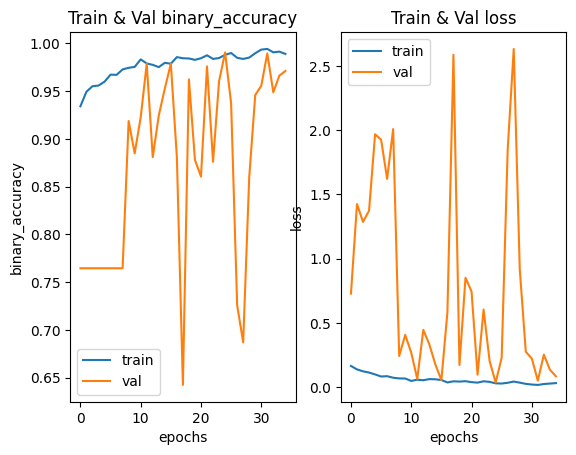

In [ ]:

fig, ax = plt.subplots(1, 2, )
ax = ax.ravel()

for i, met in enumerate(["binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Train & Val {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])